<a href="https://colab.research.google.com/github/forminju/youtuber-look-alike-crawler/blob/main/efficientnetb3_test_accuracy_look_alike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모델 학습을 위한 전처리 과정

In [133]:
# 토치 버전확인
import torch
print(torch.__version__)

1.13.1+cu116


In [134]:
# 라이브러리 세팅

import random
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A #증강
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split

In [135]:
# GPU 확인
print(torch.cuda.is_available())
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


In [136]:
# EfficientNet 오류 안나게..
torch.backends.cudnn.enabled = False

In [137]:
CFG = {
    'IMG_SIZE':456,
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':16,
    'SEED':42
}

# chatGPT 추천
# CFG = {
#     'embedding_size': 512,
#     'num_classes': num_classes,
#     'margin': 0.5,
#     'scale': 64,
#     'batch_size': 32,
#     'learning_rate': 0.0001,
#     'num_epochs': 50
# }

In [138]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [139]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [140]:
df = pd.read_csv('/content/drive/MyDrive/glory_match/look-alike/glory_train_df.csv')
image_root_dir = '/content/drive/MyDrive/glory_match/look-alike/pre-processed-image'

### Train, Test dataset 분리
항목별로 70%를 train, 30%를 valid로 사용합니다.

In [141]:
class_name_list = []

In [142]:
tmp=df.copy()
tmp['class'].shape
for initial in tmp['class']:
  if initial not in class_name_list:
    class_name_list.append(initial)
class_name_list

['SMO', 'CHJ', 'CDE', 'HAR', 'JJJ', 'JSI', 'OJY', 'SHE', 'SHG', 'IDH', 'IJH']

In [143]:
class_name_to_lower_case_list = [class_name.lower() for class_name in class_name_list]
class_name_to_lower_case_list

['smo', 'chj', 'cde', 'har', 'jjj', 'jsi', 'ojy', 'she', 'shg', 'idh', 'ijh']

In [144]:
for initial in class_name_to_lower_case_list:
  image_root_path = os.path.join(image_root_dir, initial)
  for i in range(len(tmp)):
    if (initial.upper() == tmp['class'][i]):
      tmp['file_name'][i] = os.path.join(image_root_path, tmp['file_name'][i])
tmp['file_name'].head()

0    /content/drive/MyDrive/glory_match/look-alike/...
1    /content/drive/MyDrive/glory_match/look-alike/...
2    /content/drive/MyDrive/glory_match/look-alike/...
3    /content/drive/MyDrive/glory_match/look-alike/...
4    /content/drive/MyDrive/glory_match/look-alike/...
Name: file_name, dtype: object

In [145]:
train = pd.DataFrame(columns=tmp.columns)
valid = pd.DataFrame(columns=tmp.columns)

for class_name in class_name_list:
  tmp_with_class = tmp.loc[tmp['class'] == class_name]
  train_tmp, valid_tmp = train_test_split(tmp_with_class, test_size = 0.3, random_state = 42)

  train_tmp['class'] = class_name
  valid_tmp['class'] = class_name
  train = pd.concat([train, train_tmp])
  valid = pd.concat([valid, valid_tmp])

In [146]:
train

,index,file_name,class
41,41,/content/drive/MyDrive/glory_match/look-alike/...,SMO
19,19,/content/drive/MyDrive/glory_match/look-alike/...,SMO
30,30,/content/drive/MyDrive/glory_match/look-alike/...,SMO
49,49,/content/drive/MyDrive/glory_match/look-alike/...,SMO
50,50,/content/drive/MyDrive/glory_match/look-alike/...,SMO
...,...,...,...
1213,1213,/content/drive/MyDrive/glory_match/look-alike/...,IJH
1121,1121,/content/drive/MyDrive/glory_match/look-alike/...,IJH
1199,1199,/content/drive/MyDrive/glory_match/look-alike/...,IJH
1286,1286,/content/drive/MyDrive/glory_match/look-alike/...,IJH


### label을 tensor로 반환하기 위해 one-hot-encoding 적용

In [147]:
one_hot_encoded = pd.get_dummies(tmp['class'])
train_one_hot_encoded = pd.get_dummies(train['class'])
valid_one_hot_encoded = pd.get_dummies(valid['class'])

In [148]:
data = pd.concat([tmp, one_hot_encoded], axis=1)
data = data.drop(['class'], axis=1)
train = pd.concat([train, train_one_hot_encoded], axis=1)
train = train.drop(['class'], axis=1)
valid = pd.concat([valid, valid_one_hot_encoded], axis=1)
valid = valid.drop(['class'], axis=1)

In [149]:
train.head()

,index,file_name,CDE,CHJ,HAR,IDH,IJH,JJJ,JSI,OJY,SHE,SHG,SMO
41,41,/content/drive/MyDrive/glory_match/look-alike/...,0,0,0,0,0,0,0,0,0,0,1
19,19,/content/drive/MyDrive/glory_match/look-alike/...,0,0,0,0,0,0,0,0,0,0,1
30,30,/content/drive/MyDrive/glory_match/look-alike/...,0,0,0,0,0,0,0,0,0,0,1
49,49,/content/drive/MyDrive/glory_match/look-alike/...,0,0,0,0,0,0,0,0,0,0,1
50,50,/content/drive/MyDrive/glory_match/look-alike/...,0,0,0,0,0,0,0,0,0,0,1


In [150]:
valid.head()

,index,file_name,CDE,CHJ,HAR,IDH,IJH,JJJ,JSI,OJY,SHE,SHG,SMO
0,0,/content/drive/MyDrive/glory_match/look-alike/...,0,0,0,0,0,0,0,0,0,0,1
5,5,/content/drive/MyDrive/glory_match/look-alike/...,0,0,0,0,0,0,0,0,0,0,1
34,34,/content/drive/MyDrive/glory_match/look-alike/...,0,0,0,0,0,0,0,0,0,0,1
13,13,/content/drive/MyDrive/glory_match/look-alike/...,0,0,0,0,0,0,0,0,0,0,1
44,44,/content/drive/MyDrive/glory_match/look-alike/...,0,0,0,0,0,0,0,0,0,0,1


### CustomDataset

In [151]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = torch.FloatTensor(self.label_list[index])
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [152]:
train_transform = A.Compose([
    A.Resize(180, 180),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.3, 0.3), p=1),
    A.ChannelShuffle(p=0.2),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Resize(180, 180),
    ToTensorV2()
])

In [153]:
def get_labels(df):
    return df.iloc[:,2:].values

In [154]:
train_labels=get_labels(train)
valid_labels=get_labels(valid)

In [155]:
train_dataset = CustomDataset(train['file_name'].values, train_labels, transforms=train_transform)
valid_dataset = CustomDataset(valid['file_name'].values, valid_labels, transforms=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=4)

In [156]:
for x,y in train_loader:
  print(f'Image Shape: {x.shape}')
  print(f'Label Shape: {y.shape}')
  break

Image Shape: torch.Size([16, 3, 180, 180])
Label Shape: torch.Size([16, 11])


# Model Define

In [157]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [158]:
from efficientnet_pytorch import EfficientNet

In [164]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=11):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b3(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        
        ######
        
    def forward(self, x):
        x = self.backbone(x)
        
        ######
        
        x = F.sigmoid(self.classifier(x))
        return x

In [165]:
def train(model, optimizer, train_loader, valid_loader, scheduler, device):
    model.to(device)
    criterion = nn.BCELoss().to(device)
    
    best_valid_acc = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _valid_loss, _valid_acc = validation(model, criterion, valid_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Valid Loss : [{_valid_loss:.5f}] Valid ACC : [{_valid_acc:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_valid_acc)
            
        if best_valid_acc < _valid_acc:
            best_valid_acc = _valid_acc
            best_model = model
    
    return best_model

In [166]:
def validation(model, criterion, valid_loader, device):
    model.eval()
    valid_loss = []
    valid_acc = []
    with torch.no_grad():
        for imgs, labels in tqdm(iter(valid_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            probs = model(imgs)
            
            loss = criterion(probs, labels)
            
            probs  = probs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            preds = probs > 0.5
            batch_acc = (labels == preds).mean()
            
            valid_acc.append(batch_acc)
            valid_loss.append(loss.item())
        
        _valid_loss = np.mean(valid_loss)
        _valid_acc = np.mean(valid_acc)
    
    return _valid_loss, _valid_acc

In [163]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, valid_loader, scheduler, device)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

  0%|          | 0/57 [00:00<?, ?it/s]

ValueError: ignored

In [31]:
PATH = '/content/drive/MyDrive/glory_match/'

In [32]:
torch.save(model, PATH + 'densenet.pt') 

In [33]:
torch.save(model.state_dict(), PATH + 'densenet_dict.pt')

In [34]:
torch.save({
    'densenet': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'densenet_all.tar') 

# Inference

In [122]:
PATH = '/content/drive/MyDrive/glory_match/test (1)/'

In [123]:
test = pd.read_csv('/content/drive/MyDrive/glory_match/glory_test_df.csv')

In [124]:
tmp_test = test.copy()

In [125]:
one_hot_encoded = pd.get_dummies(tmp_test['class'])
test= pd.concat([tmp_test, one_hot_encoded], axis=1)
test = test.drop(['class'], axis=1); test

,index,file_name,cde,chj,har,idh,ijh,jjj,jsi,ojy,she,shg,smo
0,1,test_cde_000001.jpg,1,0,0,0,0,0,0,0,0,0,0
1,2,test_cde_000002.jpg,1,0,0,0,0,0,0,0,0,0,0
2,3,test_cde_000003.jpg,1,0,0,0,0,0,0,0,0,0,0
3,4,test_cde_000004.jpg,1,0,0,0,0,0,0,0,0,0,0
4,5,test_cde_000005.jpg,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,632,test_smo_000073.jpg,0,0,0,0,0,0,0,0,0,0,1
632,633,test_smo_000074.jpg,0,0,0,0,0,0,0,0,0,0,1
633,634,test_smo_000075.jpg,0,0,0,0,0,0,0,0,0,0,1
634,635,test_smo_000076.jpg,0,0,0,0,0,0,0,0,0,0,1


In [126]:
test['file_name'] = PATH + test['file_name']; test

,index,file_name,cde,chj,har,idh,ijh,jjj,jsi,ojy,she,shg,smo
0,1,/content/drive/MyDrive/glory_match/test (1)/te...,1,0,0,0,0,0,0,0,0,0,0
1,2,/content/drive/MyDrive/glory_match/test (1)/te...,1,0,0,0,0,0,0,0,0,0,0
2,3,/content/drive/MyDrive/glory_match/test (1)/te...,1,0,0,0,0,0,0,0,0,0,0
3,4,/content/drive/MyDrive/glory_match/test (1)/te...,1,0,0,0,0,0,0,0,0,0,0
4,5,/content/drive/MyDrive/glory_match/test (1)/te...,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,632,/content/drive/MyDrive/glory_match/test (1)/te...,0,0,0,0,0,0,0,0,0,0,1
632,633,/content/drive/MyDrive/glory_match/test (1)/te...,0,0,0,0,0,0,0,0,0,0,1
633,634,/content/drive/MyDrive/glory_match/test (1)/te...,0,0,0,0,0,0,0,0,0,0,1
634,635,/content/drive/MyDrive/glory_match/test (1)/te...,0,0,0,0,0,0,0,0,0,0,1


In [127]:
test['index'] = test['index']-1; test

,index,file_name,cde,chj,har,idh,ijh,jjj,jsi,ojy,she,shg,smo
0,0,/content/drive/MyDrive/glory_match/test (1)/te...,1,0,0,0,0,0,0,0,0,0,0
1,1,/content/drive/MyDrive/glory_match/test (1)/te...,1,0,0,0,0,0,0,0,0,0,0
2,2,/content/drive/MyDrive/glory_match/test (1)/te...,1,0,0,0,0,0,0,0,0,0,0
3,3,/content/drive/MyDrive/glory_match/test (1)/te...,1,0,0,0,0,0,0,0,0,0,0
4,4,/content/drive/MyDrive/glory_match/test (1)/te...,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,631,/content/drive/MyDrive/glory_match/test (1)/te...,0,0,0,0,0,0,0,0,0,0,1
632,632,/content/drive/MyDrive/glory_match/test (1)/te...,0,0,0,0,0,0,0,0,0,0,1
633,633,/content/drive/MyDrive/glory_match/test (1)/te...,0,0,0,0,0,0,0,0,0,0,1
634,634,/content/drive/MyDrive/glory_match/test (1)/te...,0,0,0,0,0,0,0,0,0,0,1


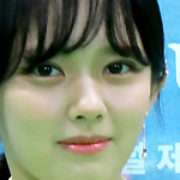

In [128]:
Image.open(test['file_name'][0])

In [129]:
test_dataset = CustomDataset(test['file_name'].values, None, valid_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [168]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            probs = model(imgs)

            probs  = probs.cpu().detach().numpy()
            preds = probs > 0.5
            preds = preds.astype(int)
            predictions += preds.tolist()
    return predictions

In [169]:
preds = inference(b3, test_loader, device)

  0%|          | 0/40 [00:00<?, ?it/s]

In [170]:
test_2 = test.copy()
test_2.iloc[:,2:] = preds; test_2

,index,file_name,cde,chj,har,idh,ijh,jjj,jsi,ojy,she,shg,smo
0,0,/content/drive/MyDrive/glory_match/test (1)/te...,1,0,0,0,0,0,0,0,0,0,0
1,1,/content/drive/MyDrive/glory_match/test (1)/te...,1,0,0,0,0,0,0,0,0,0,0
2,2,/content/drive/MyDrive/glory_match/test (1)/te...,1,0,0,0,0,0,0,0,0,0,0
3,3,/content/drive/MyDrive/glory_match/test (1)/te...,1,0,0,0,0,0,0,0,0,0,0
4,4,/content/drive/MyDrive/glory_match/test (1)/te...,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,631,/content/drive/MyDrive/glory_match/test (1)/te...,0,0,0,0,0,0,0,0,0,0,0
632,632,/content/drive/MyDrive/glory_match/test (1)/te...,0,0,0,0,0,0,0,0,0,0,0
633,633,/content/drive/MyDrive/glory_match/test (1)/te...,0,0,0,0,0,0,0,0,0,0,1
634,634,/content/drive/MyDrive/glory_match/test (1)/te...,0,0,0,0,0,0,0,0,0,0,0


In [171]:
test_2.iloc[:,2:]

,cde,chj,har,idh,ijh,jjj,jsi,ojy,she,shg,smo
0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
631,0,0,0,0,0,0,0,0,0,0,0
632,0,0,0,0,0,0,0,0,0,0,0
633,0,0,0,0,0,0,0,0,0,0,1
634,0,0,0,0,0,0,0,0,0,0,0


In [172]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test.iloc[:,2:], test_2.iloc[:,2:])

print("Accuracy:", accuracy)

Accuracy: 0.40408805031446543


In [167]:
b3= torch.load('/content/drive/MyDrive/glory_match/efficientb3.pt')
b3.eval()

BaseModel(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_